In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from pathlib import Path
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"


In [2]:
# 1. Load Data Splits
# ------------------------------------------------------------------------------
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2. Strict Feature Selection (23 Features)
# ------------------------------------------------------------------------------

# A. Identifiers & Timing (4 features)
feat_timing = [
    "day_idx", 
    "hour_of_day",
    "ts_vm_created",      # Added
    "ts_first_vm_created" # Added
]

# B. Static VM Config & Deployment Metadata (8 features)
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour"
]

# C. Tenant History Features (10 features)
# Derived from 04_tenant_history_features.ipynb
feat_history = [
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean"
]

# D. Categorical Features (1 feature)
feat_categorical = ["vm_category"]

# Combine all 23 features
ALL_FEATURES = feat_timing + feat_static + feat_history + feat_categorical

print(f"\n--- Feature Check ---")
print(f"Timing: {len(feat_timing)}")
print(f"Static: {len(feat_static)}")
print(f"History: {len(feat_history)}")
print(f"Categorical: {len(feat_categorical)}")
print(f"Total Features: {len(ALL_FEATURES)}")


--- Feature Check ---
Timing: 4
Static: 8
History: 10
Categorical: 1
Total Features: 23


In [4]:
# 3. Prepare Data for LightGBM
# ------------------------------------------------------------------------------
def prepare_for_lgbm(df_polars):
    # Select features + target
    df_pd = df_polars.select(ALL_FEATURES + [TARGET_COL]).to_pandas()
    
    # Separate X and y
    X = df_pd[ALL_FEATURES].copy()
    y = df_pd[TARGET_COL].values.ravel()
    
    # Cast categorical columns to 'category' dtype for LightGBM
    for cat_col in feat_categorical:
        X[cat_col] = X[cat_col].astype('category')
        
    return X, y

X_train, y_train = prepare_for_lgbm(df_train)
X_val, y_val     = prepare_for_lgbm(df_val)
X_test, y_test   = prepare_for_lgbm(df_test)

print(f"\nData Ready.")
print(f"Train Positive Rate: {y_train.mean():.2%} (Count: {y_train.sum()})")


Data Ready.
Train Positive Rate: 35.93% (Count: 227239)


In [5]:
# 4. Configure & Train LightGBM
# ------------------------------------------------------------------------------
print("\n--- Starting LightGBM Training ---")

# Calculate imbalance ratio for scale_pos_weight
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count
print(f"Scale Weight (Neg/Pos): {scale_weight:.2f}")


clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.03,       # Low learning rate for better generalization
    num_leaves=31,            # Standard tree complexity
    max_depth=-1,
    scale_pos_weight=scale_weight, # Handle the ~2.6% imbalance
    random_state=42,
    n_jobs=-1,
    importance_type='gain'
)


"""
clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    # Remove scale_pos_weight
    is_unbalance=True,  # Let LightGBM handle it automatically
    n_estimators=1000,
    learning_rate=0.03
)
"""

# Train with Early Stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("--- Training Complete ---")


--- Starting LightGBM Training ---
Scale Weight (Neg/Pos): 1.78
[LightGBM] [Info] Number of positive: 227239, number of negative: 405187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3563
[LightGBM] [Info] Number of data points in the train set: 632426, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359313 -> initscore=-0.578346
[LightGBM] [Info] Start training from score -0.578346
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.84308	val's auc: 0.844092
Early stopping, best iteration is:
[127]	train's auc: 0.846019	val's auc: 0.845254
--- Training Complete ---



Best validation threshold (F1): 0.488

[Validation] threshold=0.488
AUC-PR=0.7554, AUC-ROC=0.8453
Classification report:
              precision    recall  f1-score   support

           0      0.868     0.816     0.841     90628
           1      0.627     0.714     0.668     39377

    accuracy                          0.785    130005
   macro avg      0.748     0.765     0.754    130005
weighted avg      0.795     0.785     0.789    130005

Confusion matrix (counts):
                       Pred: not critical  Pred: critical
Actual: not critical               73937           16691
Actual: critical                   11263           28114


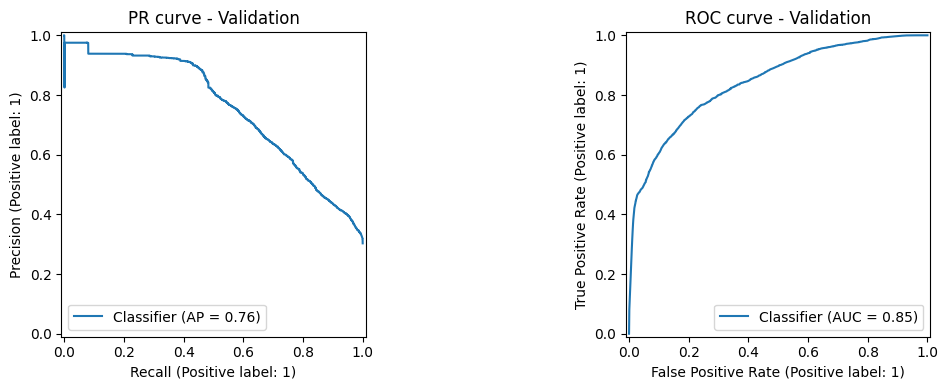


[Test] threshold=0.488
AUC-PR=0.7406, AUC-ROC=0.8252
Classification report:
              precision    recall  f1-score   support

           0      0.852     0.755     0.800     89173
           1      0.586     0.726     0.649     42676

    accuracy                          0.745    131849
   macro avg      0.719     0.740     0.725    131849
weighted avg      0.766     0.745     0.751    131849

Confusion matrix (counts):
                       Pred: not critical  Pred: critical
Actual: not critical               67300           21873
Actual: critical                   11691           30985


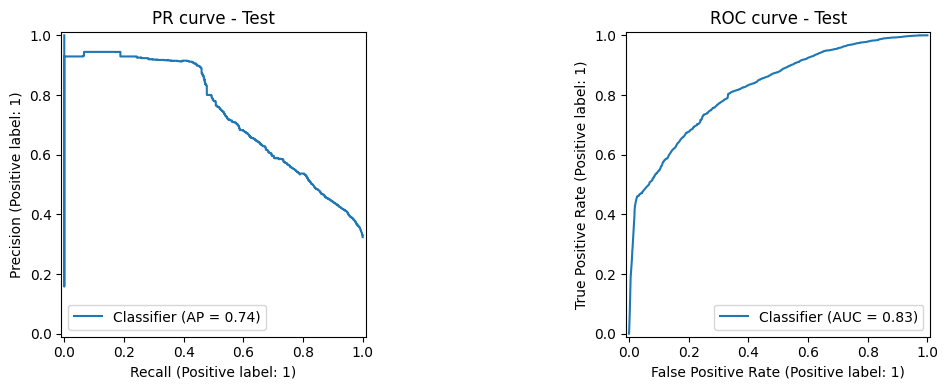

In [6]:
# 5. Evaluate on Validation/Test (PR + ROC + Confusion)
# ------------------------------------------------------------------------------

def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5):
    # Print metrics + confusion matrix and show PR/ROC curves for a split.
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: not critical", "Actual: critical"],
        columns=["Pred: not critical", "Pred: critical"],
    )

    print(f"\n[{split_name}] threshold={threshold:.3f}")
    print(f"AUC-PR={auc_pr:.4f}, AUC-ROC={auc_roc:.4f}")
    print("Classification report:")
    print(classification_report(y, preds, digits=3, zero_division=0))
    print("Confusion matrix (counts):\n", cm_df)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[0])
    axes[0].set_title(f"PR curve - {split_name}")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"ROC curve - {split_name}")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}

proba_val = clf.predict_proba(X_val)[:, 1]
candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

print(f"\nBest validation threshold (F1): {best_threshold:.3f}")

val_metrics = evaluate_split(clf, X_val, y_val, "Validation", threshold=best_threshold)
test_metrics = evaluate_split(clf, X_test, y_test, "Test", threshold=best_threshold)



Top 15 Features (Gain Importance):
                      Feature    Importance
15         hist_critical_frac  4.736976e+06
22                vm_category  1.067086e+05
1                 hour_of_day  9.808705e+04
7             deployment_size  9.600340e+04
4       vm_virtual_core_count  8.571734e+04
18         hist_cpu_mean_mean  7.342777e+04
2               ts_vm_created  7.266108e+04
12                 hist_n_vms  6.887672e+04
16         hist_lifetime_mean  6.701459e+04
9           count_vms_created  5.204704e+04
17          hist_lifetime_std  5.036624e+04
21  hist_day_night_ratio_mean  4.732219e+04
20        hist_frac_gt60_mean  4.143860e+04
13            hist_n_critical  3.344831e+04
19              hist_p95_mean  3.216688e+04


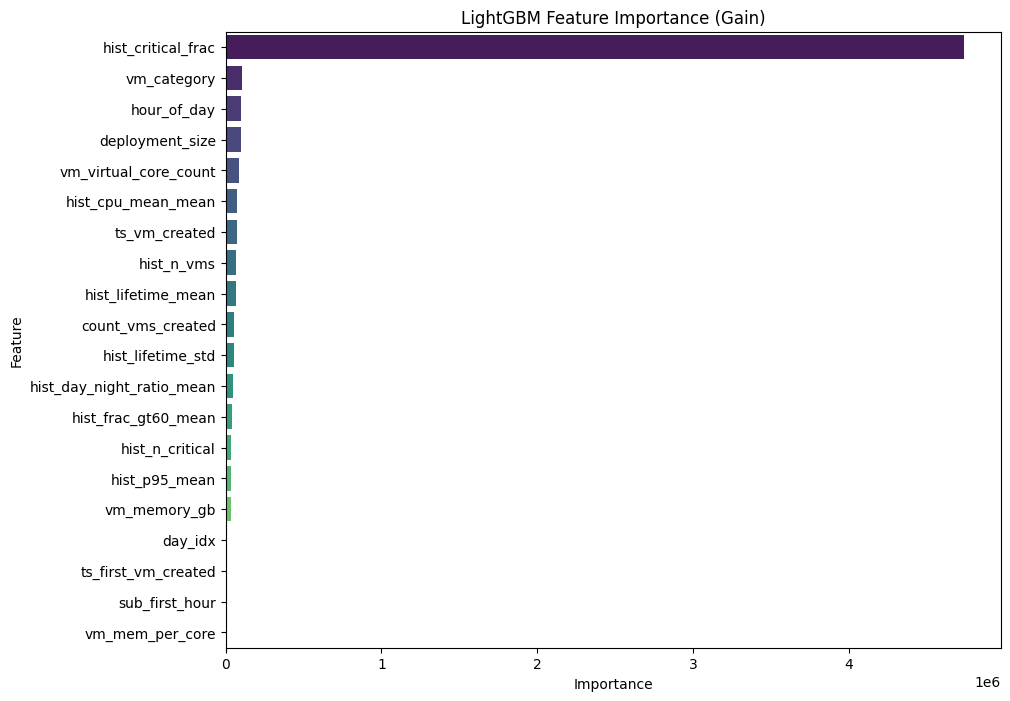

In [7]:
# 6. Feature Importance
# ------------------------------------------------------------------------------
importance = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features (Gain Importance):")
print(importance.head(15))

# Plot Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(20), x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('LightGBM Feature Importance (Gain)')
plt.show()